In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### PARAMÈTRES

In [2]:
LATENT_C = 128
Z_H, Z_W = 16, 16
UPSCALE = 8
IMG_SIZE = Z_H * UPSCALE  # 128
PATCH_SIZE = 64
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### CHARGEMENT DE LA TEXTURE

In [3]:
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # [0,1] → [-1,1]
])

img = Image.open("../Textures/gravel.jpg").convert("RGB")
real_img = transform(img).unsqueeze(0).to(DEVICE)  # (1, 3, H, W)

### GÉNÉRATEUR

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(latent_c, 256, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

### DISCRIMINATEUR

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, 4)
        )

    def forward(self, x):
        return self.net(x)

In [6]:
# ======== INIT ========
G = Generator(LATENT_C).to(DEVICE)
D = Discriminator().to(DEVICE)
opt_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [7]:
# ======== UTILS ========
def sample_z(batch_size):
    return torch.randn(batch_size, LATENT_C, Z_H, Z_W, device=DEVICE)

def random_patch_batch(img, size, batch):
    B, C, H, W = img.shape
    patches = []
    for _ in range(batch):
        top = torch.randint(0, H - size, (1,))
        left = torch.randint(0, W - size, (1,))
        patch = img[:, :, top:top+size, left:left+size]
        patches.append(patch)
    return torch.cat(patches, dim=0)

[0] Loss D: 0.5624, Loss G: 0.4892


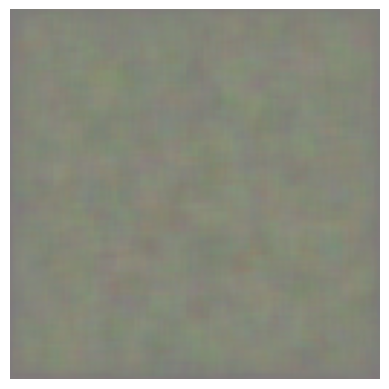

[500] Loss D: 0.2422, Loss G: 0.1368


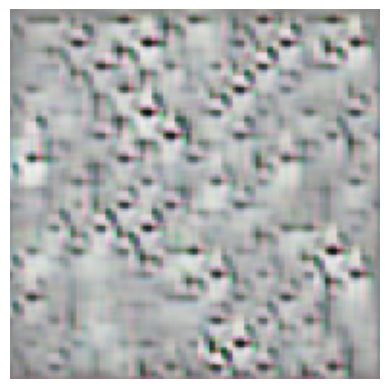

[1000] Loss D: 0.2380, Loss G: 0.1173


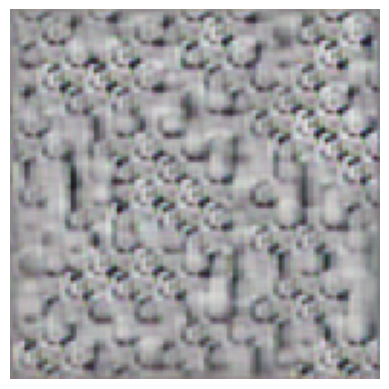

[1500] Loss D: 0.2488, Loss G: 0.1172


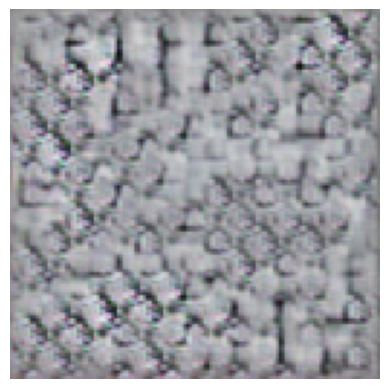

[2000] Loss D: 0.2363, Loss G: 0.1276


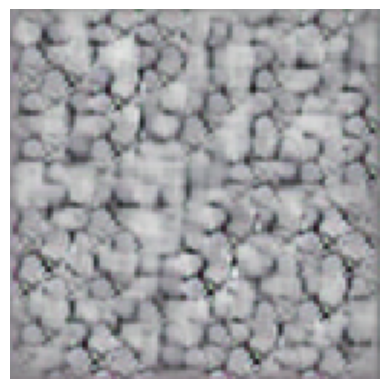

[2500] Loss D: 0.2457, Loss G: 0.4283


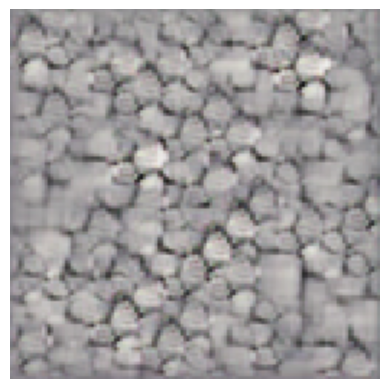

[3000] Loss D: 0.2226, Loss G: 0.1752


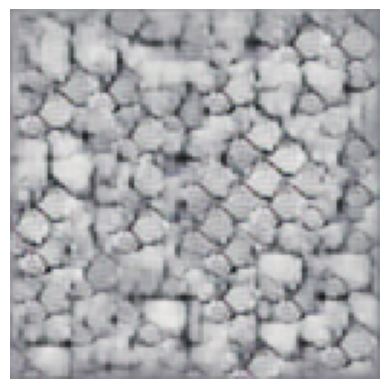

[3500] Loss D: 0.2296, Loss G: 0.1481


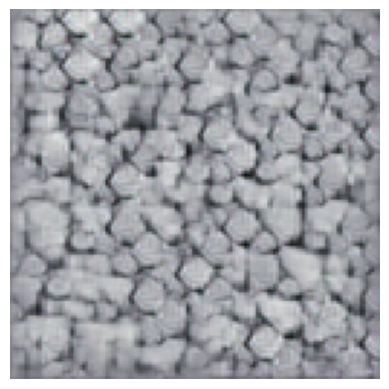

[4000] Loss D: 0.2128, Loss G: 0.1622


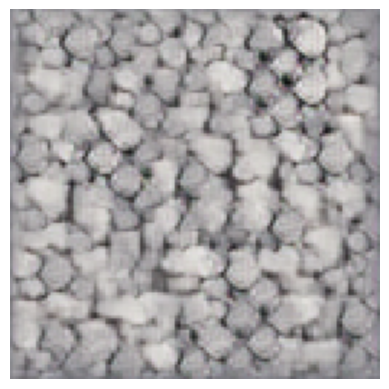

[4500] Loss D: 0.1977, Loss G: 0.2125


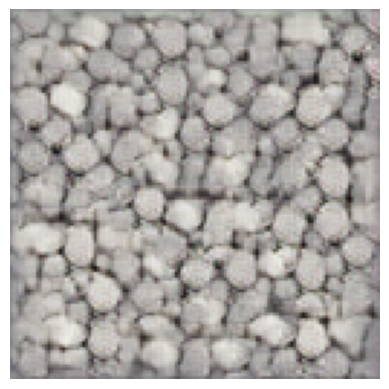

[5000] Loss D: 0.1943, Loss G: 0.1845


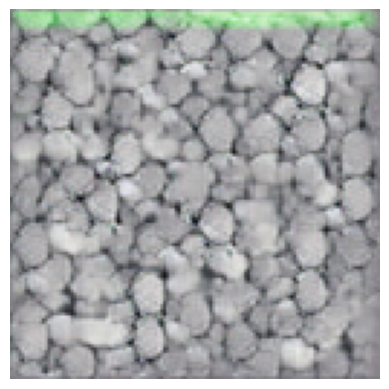

In [8]:
# ======== ENTRAÎNEMENT ========
for epoch in range(5001):
    z = sample_z(BATCH_SIZE)
    fake = G(z)

    # === Discriminateur ===
    real_patch = random_patch_batch(real_img, PATCH_SIZE, BATCH_SIZE)
    fake_patch = random_patch_batch(fake.detach(), PATCH_SIZE, BATCH_SIZE)

    real_score = D(real_patch)
    fake_score = D(fake_patch)

    loss_D = 0.5 * (torch.mean((real_score - 1)**2) + torch.mean(fake_score**2))

    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()

    # === Générateur ===
    fake_patch = random_patch_batch(G(z), PATCH_SIZE, BATCH_SIZE)
    score = D(fake_patch)
    loss_G = 0.5 * torch.mean((score - 1)**2)

    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()

    # === Visualisation ===
    if epoch % 500 == 0:
        print(f"[{epoch}] Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")
        with torch.no_grad():
            test_z = sample_z(1)
            gen = G(test_z).squeeze().permute(1, 2, 0).cpu().numpy()
            gen = (gen + 1) / 2  # [-1,1] → [0,1]
            plt.imshow(gen)
            plt.axis("off")
            plt.show()

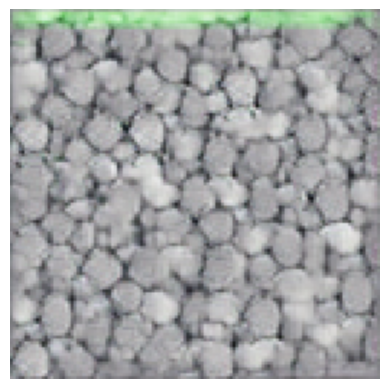

In [13]:
plt.figure()
test_z = sample_z(1)
gen = G(test_z).squeeze().permute(1, 2, 0).cpu().detach().numpy()
gen = (gen + 1) / 2  # [-1,1] → [0,1]
plt.imshow(gen)
plt.axis("off")
plt.savefig('../Generated/gravelGen.png')